# Editing a scene

## Overview

In this tutorial, you will learn how to modify a Mitsuba scene after it has been loaded from a file. You might want to edit a scene before (re-)rendering it for many reasons. Maybe a corner is dim, or an object should be moved a bit to the left. Thankfully we can use the *traverse* mechanism to perform such modifications in Python with Mitsuba 3. As we will see in later tutorials, this mechanism is also essential for inverse rendering applications and more.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>List exposed parameters of Mitsuba objects</li>
  <li>Edit a scene and update its internal state accordingly</li>
</ul>

</div>

## Loading a scene

Following the same steps as in [Mitsuba quickstart tutorial][1], let's import `mitsuba`, set the desired variant and load a scene from an XML file on disk.

[1]: https://mitsuba.readthedocs.io/en/latest/src/quickstart/mitsuba_quickstart.html

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_spectral')

scene = mi.load_file("../scenes/living-room-3/living-room-3/scene.xml")

>>>>>>>>> NEW AOVIntegrator VERSION >>>>>>>>>>>>>


Let's quickly render this scene.

In [2]:
original_image = mi.render(scene, spp=128)

# Get the film
film = scene.sensors()[0].film()

# Convert to RGB automatically via bitmap() (which includes spectrum → RGB)
bitmap = film.bitmap(raw=False)
print(bitmap)

# of spectrum channels: default 4 raw data 4
Bitmap[
  pixel_format = multichannel,
  component_format = float32,
  size = [1280, 720],
  srgb_gamma = 0,
  struct = Struct<100>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
    float32 image.R; // @12, premultiplied alpha
    float32 image.G; // @16, premultiplied alpha
    float32 image.B; // @20, premultiplied alpha
    float32 image.A; // @24, premultiplied alpha
    float32 rgb_albedo.R; // @28, premultiplied alpha
    float32 rgb_albedo.G; // @32, premultiplied alpha
    float32 rgb_albedo.B; // @36, premultiplied alpha
    float32 spec_albedo.ch0; // @40, premultiplied alpha
    float32 spec_albedo.ch1; // @44, premultiplied alpha
    float32 spec_albedo.ch2; // @48, premultiplied alpha
    float32 spec_albedo.ch3; // @52, premultiplied alpha
    float32 spec_albedo_lambda.ch0; // @56, premultiplied alpha
    float32 spec_albedo_lambda.ch1; // @60, pr

## Arbitrary Output Variables integrators (AOVs)
 Mistuba offers tutorials related to [<code>AOV</code>][1]. The following function is defined for seperating different AOV and save them in corresponding .exr file. 
 
 ** Spectral albedo is the custom AOV added at src/integrators/aov.cpp. **

[1]: https://mitsuba.readthedocs.io/en/stable/src/generated/plugins_integrators.html#arbitrary-output-variables-integrator-aov

### Save AOVs in EXR format

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import OpenEXR, Imath

def show_aov(aov, title, index):
    global _axes

    ax = _axes[index]
    ax.imshow(np.clip(aov, 0.0, 1.0))
    ax.set_title(title)
    ax.axis('off')

def save_channels_as_exr(arr, filename, channel_names):
    """Save a numpy array as EXR with given channel names."""
    arr = np.array(arr)
    H, W, C = arr.shape
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    header = OpenEXR.Header(W, H)
    header['channels'] = {ch: Imath.Channel(FLOAT) for ch in channel_names}
    out_exr = OpenEXR.OutputFile(filename, header)
    pixels = {ch: arr[:,:,i].tobytes() for i,ch in enumerate(channel_names)}
    out_exr.writePixels(pixels)
    out_exr.close()

def save_all_aovs(bitmap):
    """Save spectral albedo, RGB albedo, shading normal, depth, and world position as separate EXR files."""
    res = dict(bitmap.split())

    # --- Save RGB albedo ---
    albedo_rgb = res['rgb_albedo'] 
    save_channels_as_exr(albedo_rgb, "results/albedo0.exr", ['R','G','B'])
    show_aov(albedo_rgb, "RGB Albedo", 0)

    # --- Save Spectral albedo: 4 Hero Wavelengths ---
    albedo_spec = res['spec_albedo'] 
    save_channels_as_exr(albedo_spec, "results/albedo-spec.exr", ['R','G','B','A'])

    # --- Save Spectral albedo's corresponding wavelengths ---
    albedo_spec_wl = res['spec_albedo_lambda'] 
    save_channels_as_exr(albedo_spec_wl, "results/albedo-spec_wl.exr", ['R','G','B','A'])

    # --- Save shading normal ---
    sh_normal = res['sh_normal']
    save_channels_as_exr(sh_normal, "results/world-normal0.exr", ['R','G','B'])
    show_aov(sh_normal, "Shading Normal", 1)

    # --- Save position ---
    position = res['position']
    save_channels_as_exr(position, "results/world-pos0.exr", ['R','G','B'])
    show_aov(position, "Position", 2)

     # --- Save path traced image ---
    image = res['image']
    save_channels_as_exr(image, "results/color0.exr", ['R','G','B'])
    show_aov(image, "Path Traced Image", 3)

Channels in bitmap: ['R', 'G', 'B', 'image.R', 'image.G', 'image.B', 'image.A', 'rgb_albedo.R', 'rgb_albedo.G', 'rgb_albedo.B', 'spec_albedo.ch0', 'spec_albedo.ch1', 'spec_albedo.ch2', 'spec_albedo.ch3', 'spec_albedo_lambda.ch0', 'spec_albedo_lambda.ch1', 'spec_albedo_lambda.ch2', 'spec_albedo_lambda.ch3', 'sh_normal.X', 'sh_normal.Y', 'sh_normal.Z', 'depth.T', 'position.X', 'position.Y', 'position.Z']


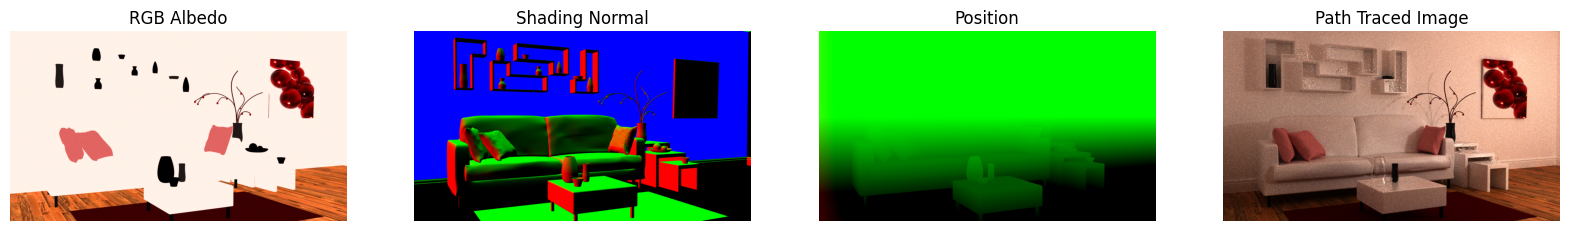

In [4]:
# Extract channel names
channel_names = [field.name for field in bitmap.struct_()]
print("Channels in bitmap:", channel_names)

# Global variables
global _fig, _axes
_fig, _axes = plt.subplots(1, 4, figsize=(20, 4))

save_all_aovs(bitmap)

## Accessing scene parameters

Any Mitsuba object can be inspected using the [<code>traverse()</code>][1] function, which returns a instance of [<code>SceneParameters</code>][2]. It has a similar API to Python `dict` and holds all parameters that are exposed by the input object and its children. Therefore, when given a scene as input, this function will return the parameters of all the objects present in the scene.

Let's print the paramters available in our teapot scene.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SceneParameters

In [5]:
params = mi.traverse(scene)
print(params)

SceneParameters[
  -----------------------------------------------------------------------------------------------------------------
  Name                                                          Flags    Type                    Parent
  -----------------------------------------------------------------------------------------------------------------
  allow_thread_reordering                                                bool                    Scene
  object_108633126838976.near_clip                                       float                   PerspectiveCamera
  object_108633126838976.far_clip                                        float                   PerspectiveCamera
  object_108633126838976.shutter_open                                    float                   PerspectiveCamera
  object_108633126838976.shutter_open_time                               float                   PerspectiveCamera
  object_108633126838976.film.size                                       ScalarVecto